Read CSV file and feed into the model
https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

tf.__version__

'2.15.0'

In [7]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
tf.keras.utils.get_file('heqi.zip', dataset_url,
                        extract=True, cache_dir='.')

# load csv file
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'
dataframe = pd.read_csv(csv_file)

In [8]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [9]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])


In [10]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


In [11]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])


In [13]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


In [15]:
train.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
1482,Dog,3,Mixed Breed,Female,Black,White,Medium,Medium,Yes,No,Healthy,150,3,1
8799,Cat,18,Domestic Short Hair,Male,Black,No Color,Large,Short,Yes,No,Healthy,0,5,0
818,Dog,6,Chihuahua,Female,Brown,No Color,Small,Short,Not Sure,No,Healthy,250,5,0
3846,Dog,24,Mixed Breed,Female,Brown,No Color,Large,Medium,Yes,Yes,Healthy,0,3,0
7452,Cat,18,Domestic Short Hair,Female,Black,Brown,Medium,Medium,Yes,Yes,Healthy,0,5,0


In [14]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [16]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

<ipython-input-14-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [18]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print(train_features)
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
{'Type': <tf.Tensor: shape=(5, 1), dtype=string, numpy=
array([[b'Cat'],
       [b'Dog'],
       [b'Dog'],
       [b'Cat'],
       [b'Dog']], dtype=object)>, 'Age': <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[6],
       [1],
       [5],
       [1],
       [2]])>, 'Breed1': <tf.Tensor: shape=(5, 1), dtype=string, numpy=
array([[b'Domestic Short Hair'],
       [b'Mixed Breed'],
       [b'Golden Retriever'],
       [b'Domestic Short Hair'],
       [b'Mixed Breed']], dtype=object)>, 'Gender': <tf.Tensor: shape=(5, 1), dtype=string, numpy=
array([[b'Male'],
       [b'Male'],
       [b'Female'],
       [b'Female'],
       [b'Male']], dtype=object)>, 'Color1': <tf.Tensor: shape=(5, 1), dtype=string, numpy=
array([[b'Black'],
       [b'Black'],
       [b'Cream'],
       [b'Yellow'],
       [b'Black']], dtype=object)>, '

In [20]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [22]:
photo_count_col = train_features['PhotoAmt']
print(photo_count_col)
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(train_features['PhotoAmt'])

tf.Tensor(
[[12]
 [ 4]
 [11]
 [ 3]
 [ 4]], shape=(5, 1), dtype=int64)


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 2.6411996 ],
       [ 0.12325157],
       [ 2.326456  ],
       [-0.19149193],
       [ 0.12325157]], dtype=float32)>

In [24]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [27]:
test_type_col = train_features['Type']
print(test_type_col)
print("=========\n\n\n")
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

tf.Tensor(
[[b'Cat']
 [b'Dog']
 [b'Dog']
 [b'Cat']
 [b'Dog']], shape=(5, 1), dtype=string)





<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [28]:
test_age_col = train_features['Age']
print(test_age_col)
print("=========\n\n\n")
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

tf.Tensor(
[[6]
 [1]
 [5]
 [1]
 [2]], shape=(5, 1), dtype=int64)





<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [30]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<ipython-input-14-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-14-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-14-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [31]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [32]:
# age
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [33]:
# remaining column
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [34]:
all_features = tf.keras.layers.concatenate(encoded_features)

# define model
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

KerasTensor(type_spec=TensorSpec(shape=(None, 48), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

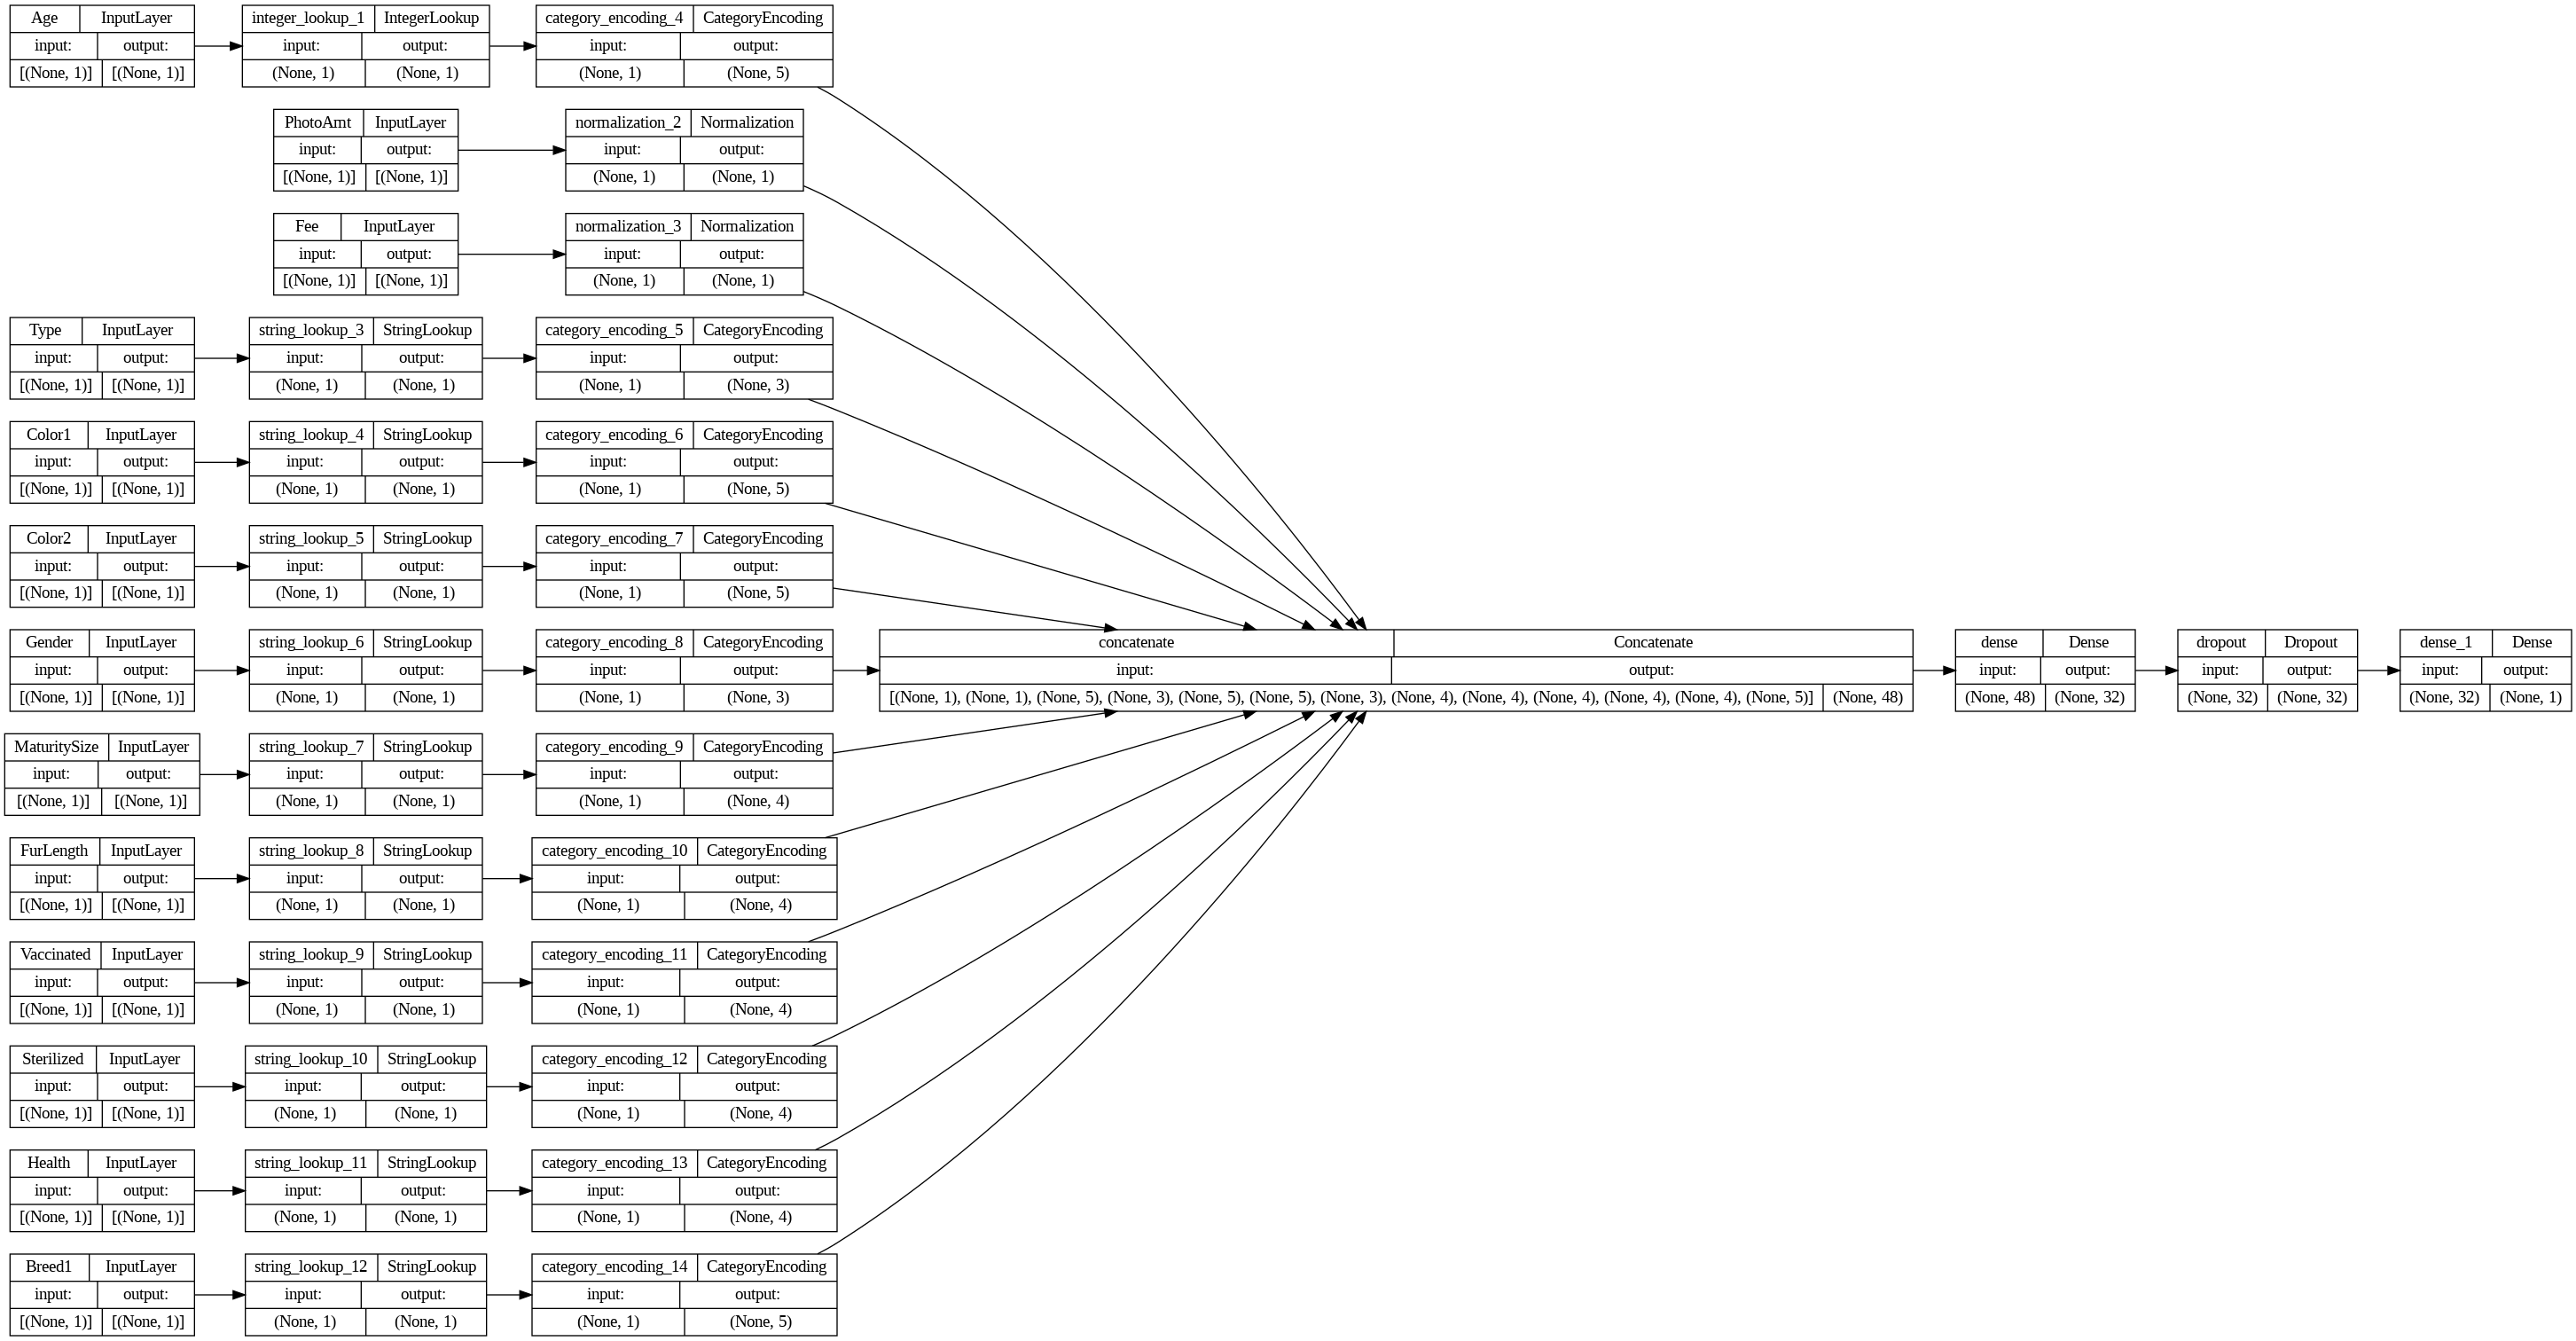

In [36]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [40]:
model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5247 - accuracy: 0.7226 - val_loss: 0.5185 - val_accuracy: 0.7201
Epoch 2/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5209 - accuracy: 0.7202 - val_loss: 0.5168 - val_accuracy: 0.7262
Epoch 3/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5218 - accuracy: 0.7188 - val_loss: 0.5159 - val_accuracy: 0.7288
Epoch 4/15
37/37 [==============================] - 0s 2ms/step - loss: 0.5203 - accuracy: 0.7269 - val_loss: 0.5148 - val_accuracy: 0.7262
Epoch 5/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5175 - accuracy: 0.7213 - val_loss: 0.5139 - val_accuracy: 0.7253
Epoch 6/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5155 - accuracy: 0.7245 - val_loss: 0.5124 - val_accuracy: 0.7322
Epoch 7/15
37/37 [==============================] - 0s 3ms/step - loss: 0.5148 - accuracy: 0.7320 - val_loss: 0.5126 - val_accuracy: 0.7227
Epoch 8/15
37/37 [==

In [41]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 3ms/step - loss: 0.5017 - accuracy: 0.7513
Accuracy 0.7512997984886169


In [42]:
model.save('my_pet_classifier.keras')
reloaded_model = tf.keras.models.load_model('my_pet_classifier.keras')

In [43]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 0s 347ms/step
This particular pet had a 71.4 percent probability of getting adopted.
